# Facial Emotion Recognition with using CNN

Facial expressions are one of the ways humans communicate. Deep learning approaches in human and computer interactions are used in artificial intelligence research as an effective system application process. The detection of emotions or facial expressions in psychology necessitates the examination and evaluation of decisions in anticipating a person's feelings or a group of people communicating. This study proposes the development of a system that can predict and recognize the classification of facial emotions using the Convolution Neural Network (CNN) algorithm and feature extraction. 

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in the notebook. Facial expressions were predicted with the accuracy of <span style="color:crimson;">62.66</span> percent with using the Convolutional Neural Network (CNN). This algorithm was evaluated on a publicly available dataset from the <span style="color:crimson;">FER2013</span> database, which has 35887 48x48 grayscale face images each representing one of the emotions.

**Table of contents of this notebook:**

**1.** [Importing necessary libraries](#1)

**2.** [Loading the data](#2)

**3.** [Data pre-processing](#3)

**4.** [Design a model](#4)

**5.** [Fine tuning](#5)

<h1 id="1"> <center>1. Importing necessary libraries</center> </h1> <a id="1"></a>

In [25]:
%%capture
!pip install scikit-plot

In [26]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

<h1 id="1"> <center>2. Loading the data</center> </h1> <a id="2"></a>

In [27]:
data = pd.read_csv("../input/fer2013/fer2013.csv")
data.shape

(35887, 3)

To see the dataset has any missing values.

In [28]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [29]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


<h1 id="1"> <center>3. Data pre-processing</center> </h1> <a id="3"></a>

In [30]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## 3.1 Shuffling the data




Firstly, we will shuffle the data using sample() function and determining fraction as 1 to shuffle the data by changing the rows.

In [31]:
data = data.sample(frac=1)

## 3.2 One Hot Encoding

Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.

In [32]:
labels = to_categorical(data[['emotion']], num_classes=7)

Changing image pixels to Numpy array


In [33]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

## 3.3 Standardization

We will change the data structure to feed the standart scaler to implement standardization process to our data. Since StandartScaler() function only takes 2 dimensional array we will reshape the data then apply our scaler to make the mean zero and standart deviation as unit. 

 

In [34]:
pixels = train_pixels.reshape((35887*2304,1))

In [35]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

## 3.4 Reshaping the data (48,48)


After that, we will reshape the data to make our image pixels ready to split operation. 

In [36]:
pixels = train_pixels.reshape((35887, 48, 48,1))

## 3.5 Train test validation split


Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


We can see some train data containing one sample of each class with the help of this plot code.

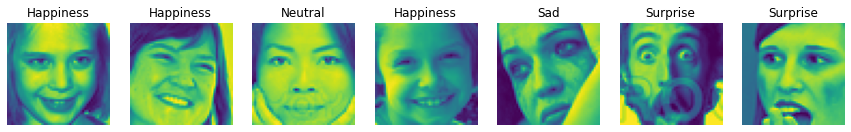

In [39]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

## 3.6 Data augmentation using ImageDataGenerator

We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.

In [40]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [41]:
datagen.fit(X_train)
valgen.fit(X_val)

In [42]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

Our dataset is ready to feed our model. We will look at our model architecture.

<h1 id="1"> <center>4.  Design a model </center> </h1> <a id="4"></a>

## 4.1 CNN model

CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model.

In [43]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [44]:
model = cnn_model()

Then, we compile our model with Adam optimizer with 0.0001 learning rate and chose metric as accuracy, then loss as categorical crossentropy

In [45]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 24, 128)      

## 4.2 Early stopping

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [47]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [48]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - 17s 34ms/step - loss: 14.0976 - accuracy: 0.1803 - val_loss: 12.8744 - val_accuracy: 0.2563

Epoch 00001: val_accuracy improved from -inf to 0.25635, saving model to best_model.h5
Epoch 2/30
455/455 [==============================] - 15s 34ms/step - loss: 12.2289 - accuracy: 0.2121 - val_loss: 11.1086 - val_accuracy: 0.2570

Epoch 00002: val_accuracy improved from 0.25635 to 0.25697, saving model to best_model.h5
Epoch 3/30
455/455 [==============================] - 15s 33ms/step - loss: 10.3029 - accuracy: 0.2296 - val_loss: 9.1880 - val_accuracy: 0.2675

Epoch 00003: val_accuracy improved from 0.25697 to 0.26749, saving model to best_model.h5
Epoch 4/30
455/455 [==============================] - 18s 40ms/step - loss: 8.4388 - accuracy: 0.2385 - val_loss: 7.4172 - val_accuracy: 0.2638

Epoch 00004: val_accuracy did not improve from 0.26749
Epoch 5/30
455/455 [==============================] - 15s 33ms/step - loss: 6.7678 - accuracy

## 4.3 Visualizing results

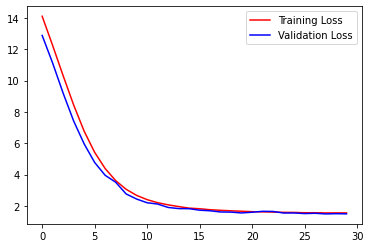

In [51]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

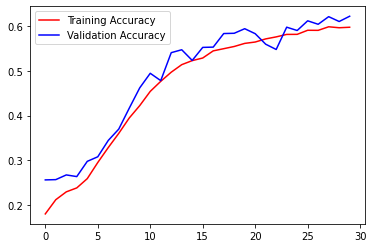

In [52]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [53]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 6ms/step - loss: 1.5022 - accuracy: 0.6160
Test Acc: 0.61604905128479


In [54]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

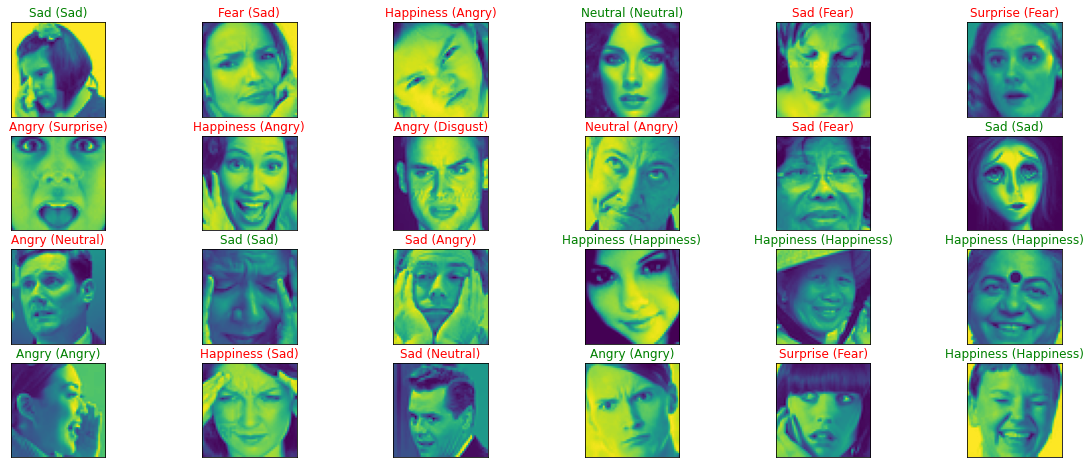

In [55]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

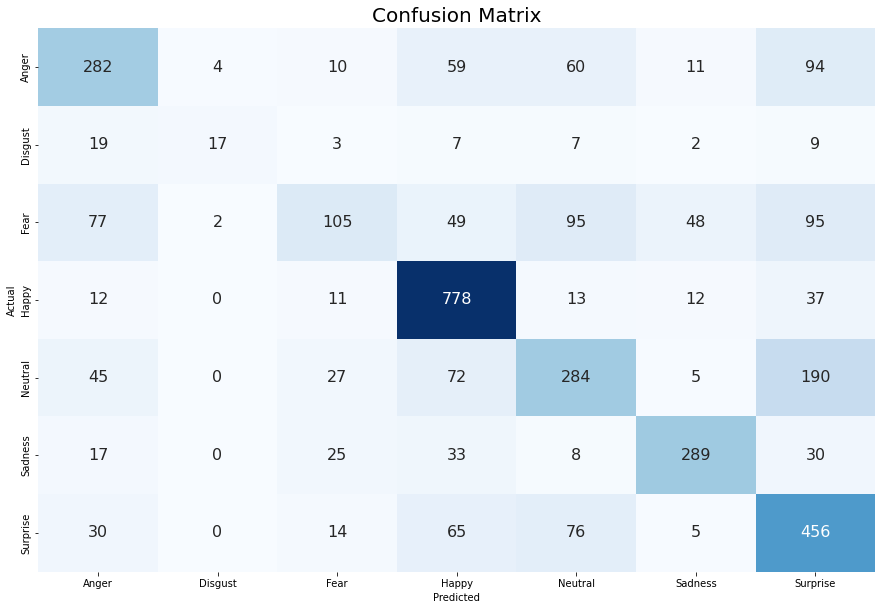

In [56]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [57]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.585     0.542     0.563       520
           1      0.739     0.266     0.391        64
           2      0.538     0.223     0.315       471
           3      0.732     0.902     0.808       863
           4      0.523     0.456     0.487       623
           5      0.777     0.719     0.747       402
           6      0.501     0.706     0.586       646

    accuracy                          0.616      3589
   macro avg      0.628     0.545     0.557      3589
weighted avg      0.613     0.616     0.598      3589



<h1 id="1"> <center>5. Fine tuning</center> </h1> <a id="5"></a>

## 5.1 Changing optimizer

Changing Optimizer to Stochastic Gradient Descent (SGD)

In [58]:
model = cnn_model()

In [59]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [60]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - 16s 32ms/step - loss: 14.8553 - accuracy: 0.1604 - val_loss: 14.1184 - val_accuracy: 0.1892

Epoch 00001: val_accuracy did not improve from 0.62229
Epoch 2/30
455/455 [==============================] - 15s 32ms/step - loss: 14.4008 - accuracy: 0.1787 - val_loss: 13.8587 - val_accuracy: 0.2186

Epoch 00002: val_accuracy did not improve from 0.62229
Epoch 3/30
455/455 [==============================] - 16s 35ms/step - loss: 14.0637 - accuracy: 0.1870 - val_loss: 13.5903 - val_accuracy: 0.2260

Epoch 00003: val_accuracy did not improve from 0.62229
Epoch 4/30
455/455 [==============================] - 14s 31ms/step - loss: 13.7848 - accuracy: 0.1934 - val_loss: 13.3489 - val_accuracy: 0.2359

Epoch 00004: val_accuracy did not improve from 0.62229
Epoch 5/30
455/455 [==============================] - 15s 33ms/step - loss: 13.5132 - accuracy: 0.2046 - val_loss: 13.1536 - val_accuracy: 0.2307

Epoch 00005: val_accuracy did not improve fro

In [61]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 6ms/step - loss: 11.7143 - accuracy: 0.2708
Test Acc: 0.2708275318145752


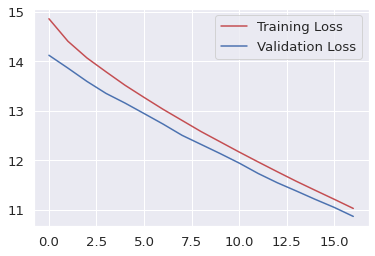

In [62]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

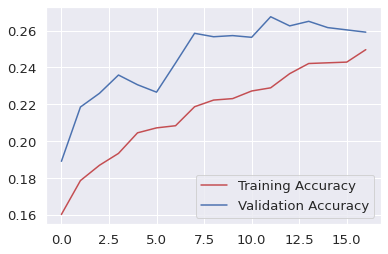

In [63]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

The model trained with SGD did not give better results than Adam optimizer.

## 5.2 Changing epoch number

Let's change the epoch number as 50 for the cnn_model.

In [64]:
model = cnn_model()

In [65]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [66]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [67]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
455/455 [==============================] - 16s 33ms/step - loss: 14.1533 - accuracy: 0.1847 - val_loss: 12.9154 - val_accuracy: 0.2542

Epoch 00001: val_accuracy improved from -inf to 0.25418, saving model to best_model.h5
Epoch 2/50
455/455 [==============================] - 16s 35ms/step - loss: 12.3474 - accuracy: 0.2118 - val_loss: 11.1871 - val_accuracy: 0.2619

Epoch 00002: val_accuracy improved from 0.25418 to 0.26192, saving model to best_model.h5
Epoch 3/50
455/455 [==============================] - 14s 32ms/step - loss: 10.4877 - accuracy: 0.2261 - val_loss: 9.4144 - val_accuracy: 0.2616

Epoch 00003: val_accuracy did not improve from 0.26192
Epoch 4/50
455/455 [==============================] - 15s 34ms/step - loss: 8.6524 - accuracy: 0.2442 - val_loss: 7.6351 - val_accuracy: 0.2824

Epoch 00004: val_accuracy improved from 0.26192 to 0.28235, saving model to best_model.h5
Epoch 5/50
455/455 [==============================] - 15s 32ms/step - loss: 7.0043 - accuracy

In [68]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 7ms/step - loss: 1.4802 - accuracy: 0.6266
Test Acc: 0.6266369223594666


In [69]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

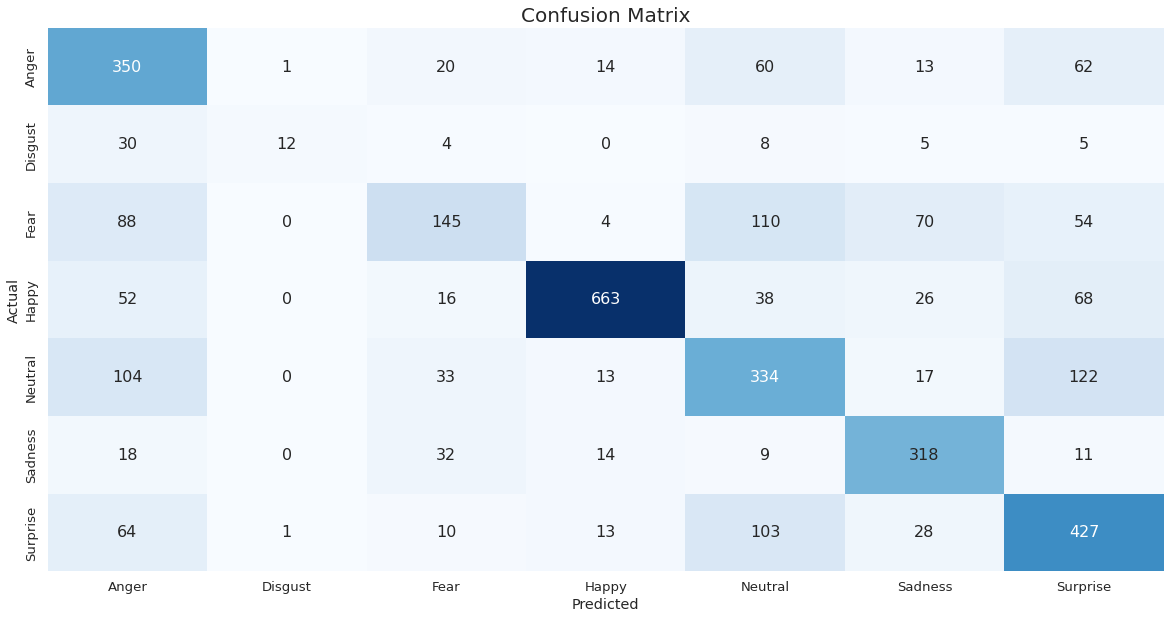

In [70]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [71]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.496     0.673     0.571       520
           1      0.857     0.188     0.308        64
           2      0.558     0.308     0.397       471
           3      0.920     0.768     0.837       863
           4      0.505     0.536     0.520       623
           5      0.667     0.791     0.724       402
           6      0.570     0.661     0.612       646

    accuracy                          0.627      3589
   macro avg      0.653     0.561     0.567      3589
weighted avg      0.646     0.627     0.623      3589



The model trained with 50 epochs has better results than the model trained with 30 epochs.